In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import math
import os

In [2]:
hitbtc_dataset = pd.read_csv('data_extracted_joint.csv', sep = ';')

In [3]:
def put_timestamps_to_first(dataset):
    rearranged_columns = ['timestamps'] + [column for column in dataset.columns if column != 'timestamps']
    return dataset[rearranged_columns]

def average_asks_and_bids(dataset):
    columns = dataset.columns
    result = {}
    for column in dataset.columns:
        if column == 'timestamps':
            result[column] = dataset[column].as_matrix()
        else:
            if 'asks' in column:
                before_asks, after_asks = column.split('asks')
                for column in dataset.columns:
                    if column != 'timestamps' and 'bids' in column:
                        before_bids, after_bids = column.split('bids')
                        if before_bids == before_asks and after_bids == after_asks:
                            second_column = column
                            break
                average_values = 0.5 * (dataset[column] + dataset[second_column])
                result[before_asks + after_asks] = average_values
    return put_timestamps_to_first(pd.DataFrame(result))            

In [4]:
average_dataset = average_asks_and_bids(hitbtc_dataset)

In [5]:

def launch(dir_for_tmp_files, dataset, id, num_to_test = 50, steps = 100, verbose = False, eval = False,\
          eta = 1, lambdaX = 1, lambdaW = 1, lambdaF = 1, standardize = True, lat_dim = 2,\
           lags = [1, 5, 10, 20, 25, 100]):
    
    name = dir_for_tmp_files + '/' + 'current_launch' + str(id) + '.csv'
    dataset.to_csv(name, sep = ';', index = False)
    if 'timestamps' in dataset.columns:
        timestamps = dataset['timestamps'].as_matrix()
    else:
        timestamps = dataset['timestamp'].as_matrix()
    
    #train_start = math.ceil(timestamps[1])
    #train_end = math.floor(timestamps[timestamps.shape[0] -num_to_test - 1])
    #test_start = math.ceil(timestamps[timestamps.shape[0] -num_to_test])
    #test_end = math.floor(timestamps[-2])
    
    #train_start = 1513357140
    train_start = math.ceil(timestamps[0])
    #train_end = 1517653140
    train_end =  math.floor(timestamps[-num_to_test])
    #test_start = 1517653260
    test_start = math.ceil(timestamps[-num_to_test])
    test_end = math.floor(timestamps[-1])
    command = "./main --dataset_path " + name + " --separator ';'"
    command += ' --train_start ' + str(train_start)
    command += ' --train_end ' + str(train_end)
    command += ' --test_start ' + str(test_start)
    command += ' --test_end ' + str(test_end)
    command += ' --steps ' + str(steps)
    
    if verbose:
        command += ' --verbose 1'
    else:
        command += ' --verbose 0'
    
    if eval:
        command += ' --eval 1'
    else:
        command += ' --eval 0'
    
    command += ' --predictions_out ' + dir_for_tmp_files + '/predictions_' + str(id) + '.csv'
    command += ' --eta ' + str(eta)
    command += ' --lambdaX ' + str(lambdaX)
    command += ' --lambdaW ' + str(lambdaW)
    command += ' --lambdaF ' + str(lambdaF)
    
    if standardize:
        command += ' --standardize 1'
    else:
        command += ' --standardize 0'
    
    command += ' --lags '
    for lag in lags:
        command += str(lag) + ' '
    
    command += ' --lat_dim ' + str(lat_dim)
    command += ' --factor_out ' + dir_for_tmp_files + '/factor_out_' + str(id)
    logs_file_name = 'logs_file_' + str(id)
    command += ' --logs_file ' + dir_for_tmp_files + '/' + logs_file_name
    #print(command)
    os.system(command)
    
    with open(dir_for_tmp_files + '/' + logs_file_name, 'r') as f:
        logs = [line for line in f]   
    
    return logs

In [6]:
import time
def measure_time(dir_for_tmp_files, dataset, id, *args, **kwargs):
    begin = time.time()
    _ = launch(dir_for_tmp_files, dataset, id, *args, **kwargs)
    end = time.time()
    return end - begin

In [7]:
measure_time('tmp', average_dataset, 1, verbose = True, steps = 1, eta = 0.01, lambdaX = 10000, \
              lambdaW = 1000, lambdaF = 0.01, eval = 1)

21.075249433517456

In [8]:
from multiprocessing import Pool, cpu_count
import tqdm
import copy
def handler(task):
    dir_for_tmp_files, dataset, id, kwargs = task
    return measure_time(dir_for_tmp_files, dataset, id, **kwargs)

def measure_times(dir_for_tmp_files, dataset, id, steps_set, **kwargs):
    tasks = []
    for steps in steps_set:
        all_kwargs = copy.deepcopy(kwargs)
        all_kwargs['steps'] = steps
        tasks.append([dir_for_tmp_files, dataset, str(id) + '___' + str(steps), all_kwargs])
    
    p = Pool(cpu_count())
    times = []
    for time in tqdm.tqdm_notebook(p.imap(handler, tasks)):
        times.append(time)    
    return times

In [9]:
num_steps = [i + 1 for i in range(10)]
times = measure_times('tmp', average_dataset, 1, num_steps,  verbose = True, eta = 0.01, lambdaX = 10000, \
              lambdaW = 1000, lambdaF = 0.01, eval = 1)

In [10]:
num_steps = [0] + num_steps
times = [0.0] + times

In [11]:
num_steps = np.asarray(num_steps)
times = np.asarray(times)

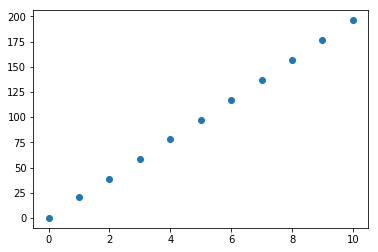

In [12]:
plt.plot(num_steps, times, 'o')
plt.show()
plt.show()

In [13]:
print((times[10] - times[1]) / 9.0)
print(times[1] - times[0])

19.452951139873928
21.01751971244812


In [14]:
def measure_iteration_time(dir_for_tmp_files, dataset, id, *args, **kwargs):
    NUM_ITERATIONS = 5
    begin = time.time()
    all_kwargs = copy.deepcopy(kwargs)
    all_kwargs['steps'] = 1
    _ = launch(dir_for_tmp_files, dataset, str(id) + '__' + 'first', *args, **all_kwargs)
    end = time.time()
    first_time = end - begin
    
    begin = time.time()
    all_kwargs = copy.deepcopy(kwargs)
    all_kwargs['steps'] = NUM_ITERATIONS
    _ = launch(dir_for_tmp_files, dataset, str(id) + '__' + 'second', *args, **all_kwargs)
    end = time.time()
    second_time = end - begin
    
    return (second_time - first_time) / (NUM_ITERATIONS - 1)  

In [15]:
measure_iteration_time('tmp', average_dataset, 1, verbose = True, eta = 0.01, lambdaX = 10000, \
              lambdaW = 1000, lambdaF = 0.01, eval = 1)

18.96048605442047

In [16]:
def handler(task):
    dir_for_tmp_files, dataset, id, kwargs = task
    return measure_iteration_time(dir_for_tmp_files, dataset, id, **kwargs)


def measure_T_time_dependence(dir_for_tmp_files, dataset, id, lengths_set, **kwargs):
    tasks = []
    for length in lengths_set:
        tasks.append([dir_for_tmp_files, dataset[0:length], str(id) + '___' + str(length), kwargs])
    
    p = Pool(cpu_count())
    times = []
    for time in tqdm.tqdm_notebook(p.imap(handler, tasks)):
        times.append(time)
    return times

In [17]:
print(average_dataset.shape)

(38574, 21)


In [18]:
lengths_set = [4000 * (i + 1) for i in range(10)]
times = measure_T_time_dependence('tmp', average_dataset, 1, lengths_set, verbose = False, eta = 0.01, lambdaX = 10000, \
              lambdaW = 1000, lambdaF = 0.01, eval = 1)

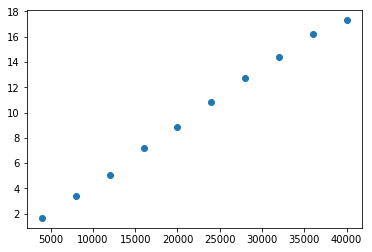

In [19]:
plt.plot(lengths_set, times, 'o')
plt.show()

In [20]:
def handler(task):
    dir_for_tmp_files, dataset, id, kwargs = task
    return measure_iteration_time(dir_for_tmp_files, dataset, id, **kwargs)


def measure_lat_dim_time_dependence(dir_for_tmp_files, dataset, id, lat_dim_set, **kwargs):
    tasks = []
    for lat_dim in lat_dim_set:
        all_kwargs = copy.deepcopy(kwargs)
        all_kwargs['lat_dim'] = lat_dim
        tasks.append([dir_for_tmp_files, dataset, str(id) + '___' + str(lat_dim), all_kwargs])
    
    p = Pool(cpu_count())
    times = []
    for time in tqdm.tqdm_notebook(p.imap(handler, tasks)):
        times.append(time)
    return times

In [21]:
lat_dim_set = [2, 4, 6, 10, 15]
times = measure_lat_dim_time_dependence('tmp', average_dataset[0:1000], 1, lat_dim_set, verbose = False, eta = 0.01, lambdaX = 10000, \
              lambdaW = 1000, lambdaF = 0.01, eval = 1)

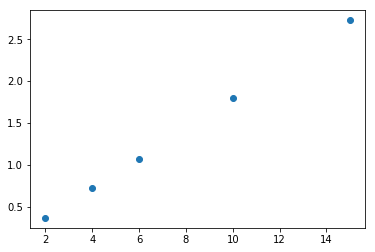

In [22]:
plt.plot(lat_dim_set, times, 'o')
plt.show()

In [23]:
def handler(task):
    dir_for_tmp_files, dataset, id, kwargs = task
    #print(kwargs)
    return measure_iteration_time(dir_for_tmp_files, dataset, id, **kwargs)


def measure_lags_time_dependence(dir_for_tmp_files, dataset, id, lags_set, **kwargs):
    tasks = []
    for lags in lags_set:
        all_kwargs = copy.deepcopy(kwargs)
        all_kwargs['lags'] = lags
        suffix = ''
        for lag in lags:
            suffix += '_' + str(lag)
        if len(suffix) > 50:
            suffix = suffix[0:50]
        tasks.append([dir_for_tmp_files, dataset, str(id) + '___' + suffix, all_kwargs])
    
    p = Pool(cpu_count())
    times = []
    for time in tqdm.tqdm_notebook(p.imap(handler, tasks)):
        times.append(time)
    return times

In [24]:
lags_set = []
for i in range(5, 50, 5):
    lags_set.append([j + 1 for j in range(i)])
    
times = measure_lags_time_dependence('tmp', average_dataset[0:3000], 1, lags_set, verbose = False,\
                                        eta = 0.01, lambdaX = 10000, \
              lambdaW = 1000, lambdaF = 0.01, eval = 1)

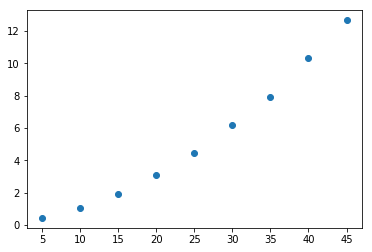

In [25]:
lengths = [len(lags) for lags in lags_set]
plt.plot(lengths, times, 'o')
plt.show()

In [26]:
from sklearn.linear_model import LinearRegression
log_lengths = np.log(np.asarray(lengths))
log_times = np.log(np.asarray(times))
clf = LinearRegression()
clf.fit(log_lengths[:, np.newaxis], log_times[:, np.newaxis])
print(clf.coef_[0])

clf = LinearRegression()
clf.fit(log_lengths[-4:, np.newaxis], log_times[-4:, np.newaxis])
print(clf.coef_[0])

[1.54995746]
[1.77871055]


In [27]:
def handler(task):
    dir_for_tmp_files, dataset, id, kwargs = task
    #print(kwargs)
    return measure_iteration_time(dir_for_tmp_files, dataset, id, **kwargs)


def measure_num_currencies_time_dependence(dir_for_tmp_files, dataset, id, num_currencies_set, **kwargs):
    tasks = []
    for num_currencies in num_currencies_set:        
        suffix = str(num_currencies)
        columns_except_timestamps = [column for column in dataset.columns if column != 'timestamps']
        columns_now = []
        for i in range(num_currencies):
            columns_now.append(columns_except_timestamps[i])
        dataset_now = dataset[['timestamps'] + columns_now]
        tasks.append([dir_for_tmp_files, dataset_now, str(id) + '___' + suffix, kwargs])
    
    p = Pool(cpu_count())
    times = []
    for time in tqdm.tqdm_notebook(p.imap(handler, tasks)):
        times.append(time)
    return times

In [28]:
print(average_dataset.shape)

(38574, 21)


In [29]:
num_currencies_set = [(i + 1) * 3 for i in range(6)]
    
times = measure_num_currencies_time_dependence('tmp', average_dataset, 1, num_currencies_set, verbose = False,\
                                        eta = 0.01, lambdaX = 10000, \
              lambdaW = 1000, lambdaF = 0.01, eval = 1)

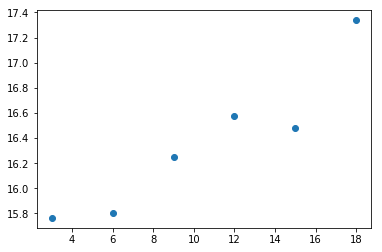

In [30]:
plt.plot(num_currencies_set, times, 'o')
plt.show()

approximately const there